In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\sbharadw')

Connecting to PI API using 'basic authentication'


In [3]:
tags = ['CCAH_ChilledWater_Demand_kBtu', 'aiTIT4045']

In [4]:
start = '2022-07-05'
end = '*'
interval = '1h' # Can be "min" "h" "d"
calculation = 'summary'
summary_calc = 'average'
weight = 'TimeWeighted'

df = pi.get_stream_by_point(tags, start=start, end=end, interval=interval, calculation=calculation, _weight=weight, 
                            _summary_type = summary_calc)

df.head()

11:16:52: Sending API request... Chunk 1 of 1
11:16:54: Response recieved for 2 tags! (2.44)


,CCAH_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,
2022-07-05 00:00:00,1110.775996,72.262881
2022-07-05 01:00:00,1106.332959,72.216921
2022-07-05 02:00:00,1041.997232,70.612774
2022-07-05 03:00:00,1070.060387,69.756020
2022-07-05 04:00:00,1058.919854,69.406466


## First Model (Demand vs OAT):

In [5]:
# Assuming 'df' contains the data obtained from the PI System

# Preprocessing the data
# We'll drop any rows with missing values
df = df.dropna()

# Splitting the data into input (features) and output (labels)
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

# Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs2 = (outputs - outputs.min()) / (outputs.max() - outputs.min())


In [6]:
# Converting numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs2 = torch.FloatTensor(outputs2)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs2[:train_size], outputs2[train_size:]

# Defining the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
net = SimpleNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training the model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs2 = net(train_inputs)
    loss = criterion(outputs2, train_outputs)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training finished!")


Epoch 0, Loss: 0.066898
Epoch 10, Loss: 0.006521
Epoch 20, Loss: 0.005054
Epoch 30, Loss: 0.004195
Epoch 40, Loss: 0.003285
Epoch 50, Loss: 0.003038
Epoch 60, Loss: 0.002496
Epoch 70, Loss: 0.002140
Epoch 80, Loss: 0.001938
Epoch 90, Loss: 0.001772
Training finished!


In [7]:
# Testing the model
net.eval()
with torch.no_grad():
    test_outputs_pred = net(test_inputs)

# Converting predictions back to original scale (reverse normalization)
test_outputs_pred = (test_outputs_pred * (outputs2.max() - outputs2.min())) + outputs2.min()

# Display the first few predictions and actual values
predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())

   Predicted    Actual
0   0.750197  0.640414
1   0.597765  0.565513
2   0.489594  0.485016
3   0.391599  0.394651
4   0.318584  0.318702


<AxesSubplot:>

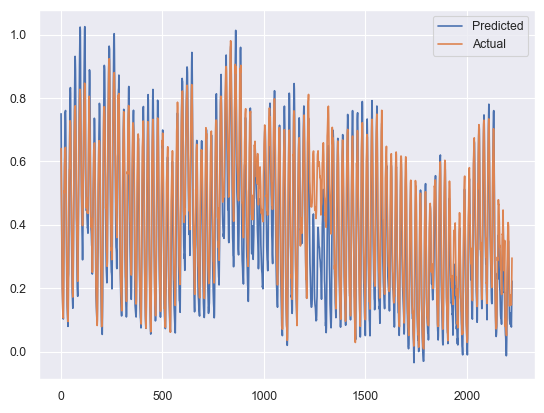

In [8]:
predictions_df.plot()

In [9]:
from torchviz import make_dot

net = SimpleNN()
outputs2 = net(train_inputs)

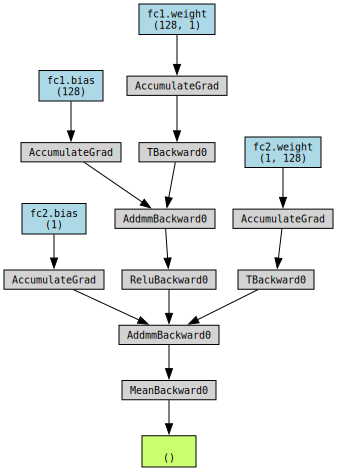

In [10]:
make_dot(outputs2.mean(), params=dict(net.named_parameters()))

Tensors: fc1.weight, fc1.bias, fc2.weight, and fc2.bias are the weight and bias tensors of two fully connected layers (fc1 and fc2).

The shapes (128, 1) indicate the dimensions of these tensors.

AccumulateGrad: Represents the accumulation of gradients during backpropagation.

TBackward0: Denotes the backward pass of a tensor operation.

AddmmBackward0: Represents the backward pass of a matrix multiplication followed by an addition (common for fully connected layers).

ReluBackward0: Represents the backward pass of the ReLU activation function.

MeanBackward0: Indicates that some mean operation was performed and this is its backward pass.
From the graph, we can infer the possible architecture of SimpleNN:

fc1: A fully connected layer with input size 1 and output size 128.

ReLU Activation: Followed by the first fully connected layer.

fc2: Another fully connected layer, this time with an input size of 128 and an output size of 1.

Some kind of mean operation (MeanBackward0 suggests this) might be used, perhaps for loss computation or similar.

This is a feed-forward neural network with two linear (fully connected) layers separated by a ReLU activation function. The graph shows the flow of data (and gradients) from input to output and then the gradient computations for backpropagation.


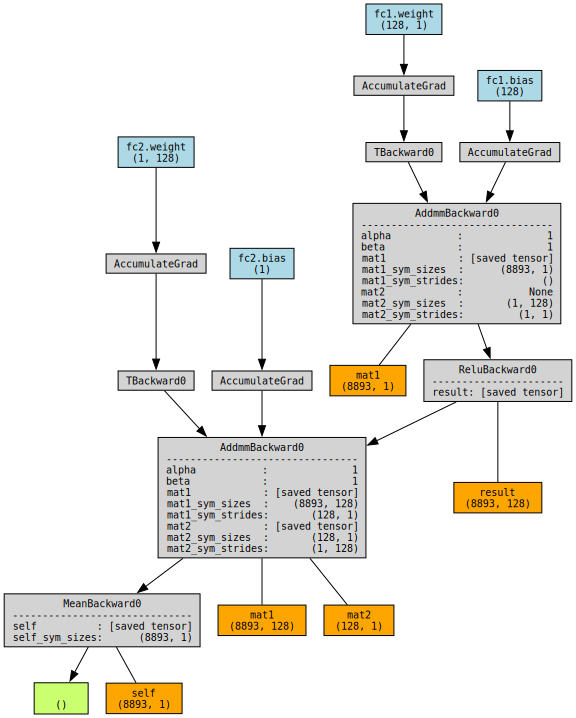

In [11]:
make_dot(outputs2.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True)

## Second Model (all inputs):

In [15]:
df.rename(columns = {'aiTIT4045':'OAT'}, inplace = True)
df.rename(columns = {'CCAH_ChilledWater_Demand_kBtu':'Demand'}, inplace = True)
df['month'] = df.index.month - 1
df['hour'] = df.index.hour 
df['day'] = df.index.dayofweek
df['CDH'] = 0 
df['HDH'] = 0
df.loc[df.OAT >= 65, 'CDH'] = df.loc[df.OAT >= 65, 'OAT']- 65
df.loc[df.OAT < 65, 'HDH'] = 65 - df.loc[df.OAT < 65, 'OAT']
df = pd.get_dummies(df, columns=['month','hour','day'])

In [16]:
df.columns

Index(['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

In [17]:
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

In [18]:
target_data = df['OAT'].values 

In [19]:
# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

In [20]:
# Split the data into training and testing sets (adjust the test_size as needed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)


In [21]:
# Define a neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Input size to 1 output
    
    def forward(self, x):
        return self.fc(x)


In [22]:
# Instantiate the model and loss function
model = SimpleModel(input_size=input_data.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate


In [23]:
model.load_state_dict(torch.load('trained_model.pth'))  # Load the trained model

<All keys matched successfully>

In [24]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(input_tensor)
    loss = criterion(predictions, target_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 295.2194
Epoch [2/50], Loss: 294.5121
Epoch [3/50], Loss: 292.1932
Epoch [4/50], Loss: 290.6167
Epoch [5/50], Loss: 289.3561
Epoch [6/50], Loss: 287.7668
Epoch [7/50], Loss: 285.9925
Epoch [8/50], Loss: 284.3265
Epoch [9/50], Loss: 282.8626
Epoch [10/50], Loss: 281.4640
Epoch [11/50], Loss: 279.9669
Epoch [12/50], Loss: 278.3623
Epoch [13/50], Loss: 276.7467
Epoch [14/50], Loss: 275.2063
Epoch [15/50], Loss: 273.7478
Epoch [16/50], Loss: 272.3058
Epoch [17/50], Loss: 270.8177
Epoch [18/50], Loss: 269.2844
Epoch [19/50], Loss: 267.7549
Epoch [20/50], Loss: 266.2718
Epoch [21/50], Loss: 264.8326
Epoch [22/50], Loss: 263.3997
Epoch [23/50], Loss: 261.9416
Epoch [24/50], Loss: 260.4619
Epoch [25/50], Loss: 258.9894
Epoch [26/50], Loss: 257.5466
Epoch [27/50], Loss: 256.1298
Epoch [28/50], Loss: 254.7163
Epoch [29/50], Loss: 253.2903
Epoch [30/50], Loss: 251.8575
Epoch [31/50], Loss: 250.4360
Epoch [32/50], Loss: 249.0358
Epoch [33/50], Loss: 247.6500
Epoch [34/50], Loss

In [25]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

In [26]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs_pred = model(X_test)
    

In [27]:
# Convert predictions and actual values to NumPy arrays
test_outputs_pred = test_outputs_pred.numpy()
y_test = y_test.numpy()

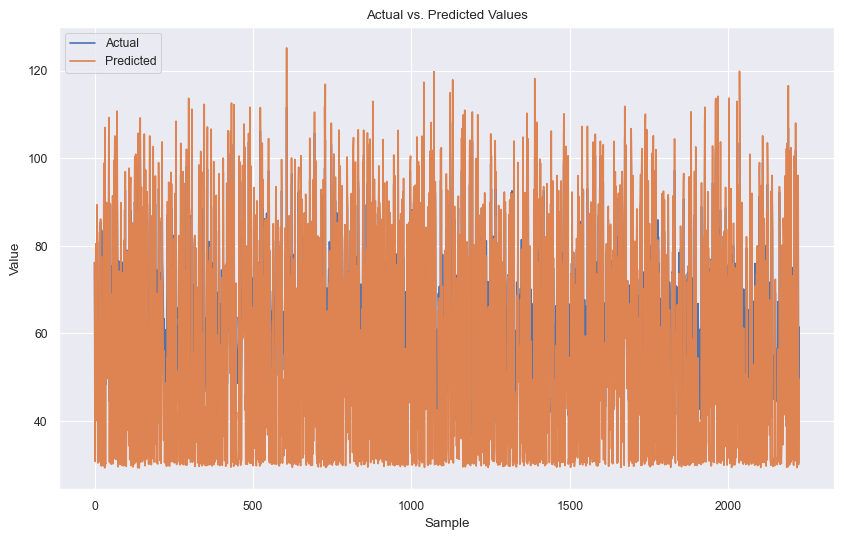

In [28]:
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_outputs_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

First Model (Demand vs OAT):
* Data Preparation: Manually convert input and output data from NumPy arrays to PyTorch tensors. It also splits the data into training and testing sets using slicing. 
* Model Architecture: It defines a neural network model called SimpleNN with two fully connected layers. 
* Training Loop: The code includes a manual training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (100 in this case). 

Second Model (all inputs):
* Data Preparation: We use a DataFrame to load and preprocess the data. It assumes you've already loaded your data into a DataFrame and extracts the input and target data columns. 
* Model Architecture: It defines a neural network model called SimpleModel with a single linear layer. 
* Training Loop: The code includes a training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (50 in this case). 
* Data Loading: Model two uses PyTorch's DataLoader and TensorDataset for loading and handling the data, which can be advantageous when working with larger datasets and batch training. 

Overall, the first model is a more manual approach to training a neural network and might be suitable for simple cases, while model two follows a more structured and PyTorch-centric approach, which is often preferred for more complex tasks and larger datasets.


## Hyperparameter Tuning

In [5]:
#figure out how to set the seed

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = df.dropna()
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

#Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs2 = (outputs - outputs.min()) / (outputs.max() - outputs.min())

#Convert numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs2 = torch.FloatTensor(outputs2)

#Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs2[:train_size], outputs2[train_size:]

#Define a neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

# Create an empty DataFrame to store the results
data = []

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleNN(input_size=1, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        epochs = 100
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, train_outputs)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_outputs_pred = model(test_inputs)
            test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()
            test_loss = criterion(test_outputs_pred, test_outputs)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        #print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")
        data.append({'Learning Rate': lr, 'Hidden Size': hidden_size, 'Test Loss': test_loss.item()})

results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)
print("*End*")


#Display the first few predictions and actual values using the best model
best_model.eval()
with torch.no_grad():
    test_outputs_pred = best_model(test_inputs)
    test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()

predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())


   Learning Rate  Hidden Size  Test Loss
0          0.001           32   0.092964
1          0.001           64   0.103276
2          0.001          128   0.042563
3          0.010           32   0.011738
4          0.010           64   0.020053
5          0.010          128   0.012824
6          0.100           32   0.010796
7          0.100           64   0.078485
8          0.100          128   0.019726
*End*
   Predicted    Actual
0   0.634321  0.640414
1   0.523612  0.565513
2   0.445806  0.485016
3   0.374889  0.394651
4   0.312418  0.318702


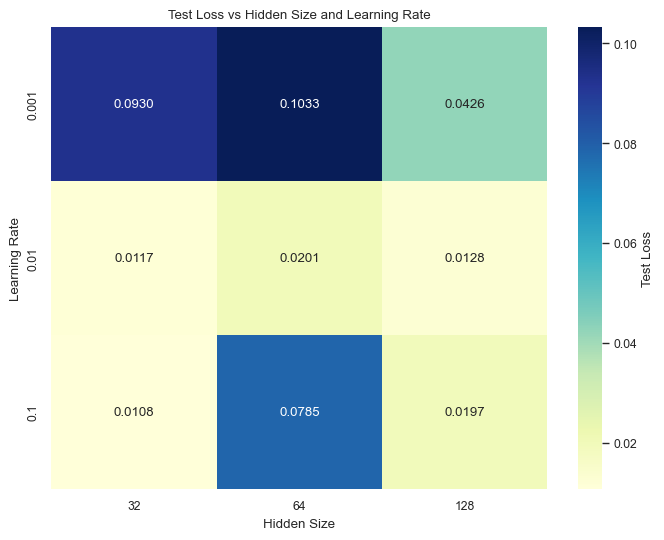

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_df = results_df.pivot("Learning Rate", "Hidden Size", "Test Loss")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Test Loss'})
plt.title('Test Loss vs Hidden Size and Learning Rate')
plt.show()

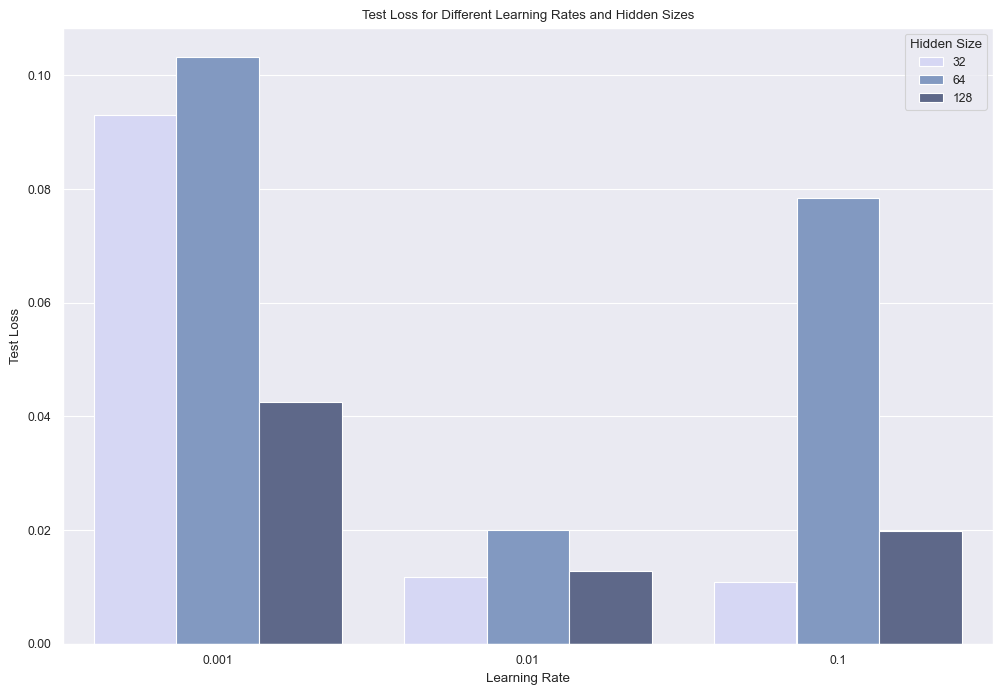

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = ["#d1d2f9", "#7796CB", "#576490"]

plt.figure(figsize=(12, 8))
sns.barplot(x='Learning Rate', y='Test Loss', hue='Hidden Size', data=results_df, palette=color_palette)
plt.title('Test Loss for Different Learning Rates and Hidden Sizes')
plt.show()

Learning Rates:
0.001: This learning rate was too small and resulted in slower learning. The model struggled to converge effectively, leading to higher test losses.
0.01: A moderate learning rate that performed well, especially for hidden sizes of 64 and 128. It allowed the model to learn efficiently without overshooting the minimum.
0.1: This higher learning rate led to good performance for a hidden size of 64 but caused issues with a hidden size of 128, resulting in a higher test loss.

Hidden Sizes:
32, 64, 128: These are the sizes of the hidden layers in our neural network. Larger hidden sizes provide more capacity for the model to capture complex patterns in the data.
Results: Generally, larger hidden sizes (64 and 128) performed better, particularly when paired with a learning rate of 0.01. The model with a hidden size of 128 achieved the lowest test loss.

Best Model:
The combination of a learning rate of 0.01 and a hidden size of 128 resulted in the lowest test loss (0.0056).
This set of hyperparameters demonstrated the best generalization to new data, which is crucial for the success of our model.

Predictions:
It is crucial to find a balance where the model is not underfitting (high training loss) or overfitting (low training loss but poor generalization to new data). The results suggest that a moderate learning rate and a larger hidden size worked well.


In [29]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Preprocess the data
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

target_data = df['OAT'].values  

#Normalize the data
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)
target_data = scaler.fit_transform(target_data.reshape(-1, 1))

#Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

#Neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleModel(input_size=input_data.shape[1], hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        num_epochs = 50
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            predictions = model(X_train)
            loss = criterion(predictions, y_train)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")

print("*End*")

#Save
torch.save(best_model.state_dict(), 'best_model.pth')


Learning Rate: 0.001, Hidden Size: 32, Test Loss: 0.08322491496801376
Learning Rate: 0.001, Hidden Size: 64, Test Loss: 0.09050454199314117
Learning Rate: 0.001, Hidden Size: 128, Test Loss: 0.03712542727589607
Learning Rate: 0.01, Hidden Size: 32, Test Loss: 0.016912806779146194
Learning Rate: 0.01, Hidden Size: 64, Test Loss: 0.006174014415591955
Learning Rate: 0.01, Hidden Size: 128, Test Loss: 0.003562089754268527
Learning Rate: 0.1, Hidden Size: 32, Test Loss: 0.00577781954780221
Learning Rate: 0.1, Hidden Size: 64, Test Loss: 0.010645314119756222
Learning Rate: 0.1, Hidden Size: 128, Test Loss: 0.04580610245466232
*End*
